In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date_str = str(last_date[0]).split("-")
last_date_dt = dt.date(int(last_date_str[0]),int(last_date_str[1]),int(last_date_str[2]))
last_date_dt

datetime.date(2017, 8, 23)

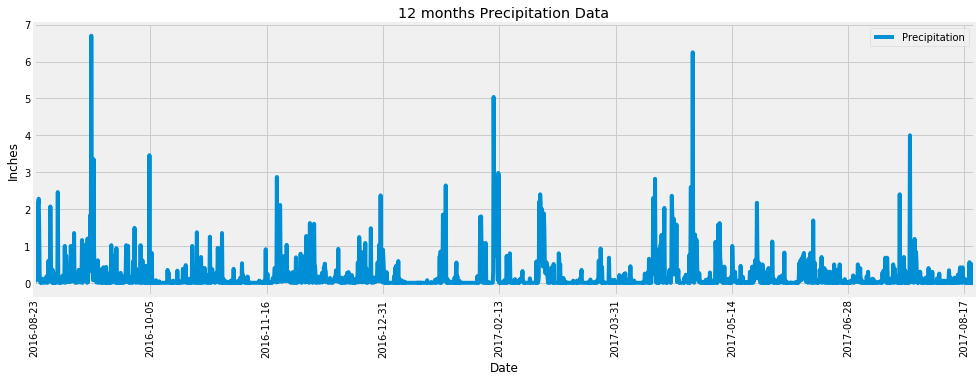

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
prec_last12 = session.query(Measurement.date, Measurement.prcp).\
filter(Measurement.date <= last_date_dt).\
filter(Measurement.date >= (last_date_dt-dt.timedelta(days=365))).all()

# Calculate the date 1 year ago from the last data point in the database

# Perform a query to retrieve the data and precipitation scores

# Save the query results as a Pandas DataFrame and set the index to the date column

# Sort the dataframe by date
measurement_df = pd.DataFrame(prec_last12, columns=('date', 'Precipitation'))
measurement_df = measurement_df.dropna()
measurement_df = measurement_df.sort_values(by='date')
measurement_df = measurement_df.set_index('date')
measurement_df.head()
# Use Pandas Plotting with Matplotlib to plot the data
measurement_df.plot(title='12 months Precipitation Data', figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Inches')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
measurement_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station).count()

print(f'There are {num_stations} stations in this dataset')

There are 9 stations in this dataset


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

query = session.query(Station.station, Station.name, func.count(Station.station)).filter(Station.station == Measurement.station).group_by(Station.id).order_by(func.count(Station.station).desc()).all()

for record in query:
    print(record)


('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active = session.query(Station.station, Station.name, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Station.station == Measurement.station).group_by(Station.id).order_by(func.count(Station.station).desc()).limit(1).all()
for station in most_active:
    station_id, station_name, min_temp, max_temp, avg_temp = station
    print(f'The most active station was number {station_id}, named {station_name}.\n')
    print(f'''It has recorded the following parameters
    The minimum temperature was: {min_temp:.2f}
    The maximum temperature was : {max_temp:.2f}
    And an average of: {avg_temp:.2f}
    ''')
    most_active_id = station_id

The most active station was number USC00519281, named WAIHEE 837.5, HI US.

It has recorded the following parameters
    The minimum temperature was: 54.00
    The maximum temperature was : 85.00
    And an average of: 71.66
    


In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_last12 = session.query(Measurement.date, Measurement.tobs).\
filter(Measurement.date <= last_date_dt).\
filter(Measurement.date >= (last_date_dt-dt.timedelta(days=365))).\
filter(Measurement.station == most_active_id).all()
temp_obs = pd.DataFrame(tobs_last12)


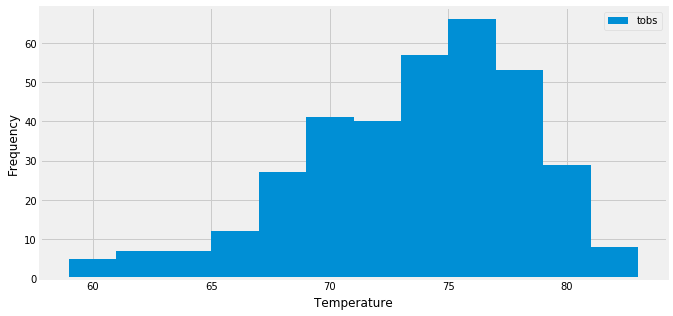

In [17]:
temp_obs.plot.hist(bins=12,figsize=(10,5))
plt.xlabel('Temperature')
plt.show()

## Bonus Challenge Assignment

In [19]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    results = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).all()
    for min, max, avg in results:
        min = min
        max = max
        avg = avg
    return print(f'The min, max, avg temperatures between {start_date} and {end_date} were: min({min}), max:({max}) and avg:({avg:.2f})')
    
    # session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
     #   filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
calc_temps('2012-02-28', '2012-03-05')

The min, max, avg temperatures between 2012-02-28 and 2012-03-05 were: min(62.0), max:(74.0) and avg:(69.57)


In [20]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
calc_temps('2016-08-23','2017-08-23')

The min, max, avg temperatures between 2016-08-23 and 2017-08-23 were: min(58.0), max:(87.0) and avg:(74.59)
